2440893


Populating the interactive namespace from numpy and matplotlib
最大准确率阈值: 0.81
最大准确率: 0.6394849785407726


D:\developpython\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


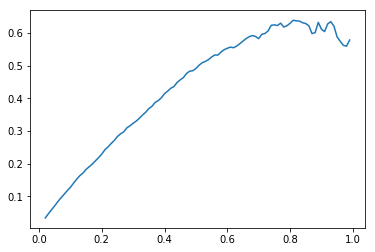

In [1]:
import pandas as pd
import datetime
import re
import math
from collections import Counter
DATA_PATH = "./data"

# 读入数据阶段
with open(DATA_PATH+"/stopwords.txt", 'r') as file:
    stopwords = file.read()
stopwords = stopwords.split('\n')

amazon_df = pd.read_csv(DATA_PATH+"/Amazon.csv")
google_df = pd.read_csv(DATA_PATH+"/Google.csv")
perfectMap_df = pd.read_csv(DATA_PATH+"/Amazon_Google_perfectMapping.csv")
perfectMap = []

def buildPerfectMap(x):
    perfectMap.append((x['idAmazon'], x['idGoogleBase']))
perfectMap_df.apply(buildPerfectMap, axis=1)
pass

def tokenize(string):
    if not type(string) is str:
        return []
    split_regex = '\w+'
    string = string.lower()
    tokens = re.findall(split_regex, string)
    for word in stopwords:  # 读取所有停用词，并在 list 中删除
        while word in tokens:
            tokens.remove(word)
    return tokens
def rec2tok(x, dic):
    # x:a record from on DataFrame
    # dic:dictionary that build mappings from record id to tokens
    if not type(x['description']) is str:
        x['description'] = ''
    if not type(x['manufacturer']) is str:
        x['manufacturer'] = ''
    dic[x['id']] = tokenize(x['title'] + ' ' + x['description'] + ' ' + x['manufacturer'])
def inc(i, dic):
    # i:a key in dic
    # dic:dic[i]++
    if i in dic: 
        dic[i] += 1
    else: 
        dic[i] = 1
    
def tf(tokens):# 计算 tokens 中所有 token 的 tf 值
    tfs = {}
    for token in tokens: 
        inc(token, tfs)
    n = float(len(tokens))
    for token in tfs:
        tfs[token] /= n
    return tfs

def idf(tokens_dict):
    idfs = {}
    N = float(len(amazon_df)+len(google_df)) # tokens 列表的个数，即 Amazon.csv, Google.csv 中每一行对应一个 tokens
    for tid in tokens_dict:                  # 取出 tokens 列表的的每一个 tokens，计算 tokens 内包含的 所有token，在所有tokens中出现了几次
        tokens_set = set(tokens_dict[tid])
        for token in tokens_set:
            inc(token, idfs)
    for token in idfs:
        idfs[token] = N / idfs[token]
    return idfs


def tfidf(tokens, idfs):
    ans = tf(tokens)
    for i in ans:
        ans[i] *= idfs[i]
    return ans 


def invertIndex(forward_index):
    # 返回一个 {'token': []} 的字典，即每个token在那些id中出现过
    # 即 反向索引
    ans = {}
    for i in forward_index:
        for j in forward_index[i]:
            if j in ans:
                ans[j].append(i)
            else:
                ans[j] = [i]
    return ans
def dotprod(a, b): # 计算余弦相似度的分子， a*b 的和，点积
    ans=0
    for i in a:
        if i in b: 
            ans += a[i]*b[i]
    return ans

def norm(a): # 计算余弦相似度的分母， a^2 的和，范数
    ans = 0
    for i in a:
        ans += a[i]**2
    return math.sqrt(ans)
amazon_tokens_dict = {} 
google_tokens_dict = {}

amazon_df.apply(lambda x:rec2tok(x, amazon_tokens_dict), axis=1)
google_df.apply(lambda x:rec2tok(x, google_tokens_dict), axis=1)

amazon_inv = invertIndex(amazon_tokens_dict)

idfs_full = dict(Counter(idf(amazon_tokens_dict))+Counter(idf(google_tokens_dict)))

amazon_weights = { i:tfidf(amazon_tokens_dict[i], idfs_full) for i in amazon_tokens_dict }
google_weights = { i:tfidf(google_tokens_dict[i], idfs_full) for i in google_tokens_dict }

amazon_norm = { i:norm(amazon_weights[i]) for i in amazon_weights }
google_norm = { i:norm(google_weights[i]) for i in google_weights }
def buildSim(Id, weight, norm, weights, norms, inv, sims):
    #weights : Id->token->weight
    #norms : Id->norm
    for token in weight: # 循环每一个 token
        if token in inv: # 如果该 token 在 Amazon 的数据中出现过
            for ama_tid in inv[token]: # 在哪一个 Amazon 的数据中出现过
                if not (ama_tid, Id) in sims: 
                    sims[(ama_tid, Id)] = dotprod(weight, weights[ama_tid]) / (norm*norms[ama_tid])  
                    # 计算一条 Amazon 数据与一条 Google 数据的相似度
sims={}
for i in google_weights: # 对每一行 google 的数据
    buildSim(i, google_weights[i], google_norm[i], amazon_weights, amazon_norm, amazon_inv, sims)
print(len(sims))

true_dup_sims = []


# 将准确度大于阈值的实体融合条目，加入到正确 list 中
def truepos(threshold):
    global true_dup_sims
    true_dup_sims = []
    for i in sims:
        if sims[i] > threshold: 
            true_dup_sims.append(i)


# 大于阈值的个数 - 正确识别个数(与给定perfect一致)
def falsepos(threshold):
    ans=0
    for i in true_dup_sims:
        if not i in perfectMap: 
            ans += 1
    return ans


# 融合准确率 -> 正确识别个数 / 大于阈值的个数
def precision(threshold):
    truepos(threshold)
    a = len(true_dup_sims) - falsepos(threshold)
    b = len(true_dup_sims)
    return a/b
nthresholds = 100
thresholds = [float(n) / nthresholds for n in range(2, nthresholds)]
p = [precision(n) for n in thresholds]
%pylab inline
plt.plot(thresholds, p)
for i in range(0, 98):
    if p[i] == max(p): 
        print("最大准确率阈值: {}".format(thresholds[i]))
    
print("最大准确率: {}".format(max(p)))

